## Project Milestone 4 - Linguistic Harbingers of Betrayal Extension (Feature Selection)

In this notebook, we mainly examine the different features that are provided in the dataset, look into the imbalance of different features and the correlation of different features. We will select features for the future extension work.

First, input all the libraries we need:

In [1]:
import json
import math
import numpy as np
from scipy import stats
from scipy.stats import sem
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import seaborn as sns

Get data from the json file:

In [2]:
# read data from diplomacy_data.json with reading mode
with open("diplomacy_data.json", "r") as f:
        data = json.load(f)
len(data)

500

Since we only consider dialogs that happen before the last act of friendship, we need to know when does the last act of friendship happen. Later when extracting feature values, extract them from the seasons that is before the last support season.

In [3]:
# a function to get the season where the last support between two players happened
# entry refer to one entry in the dataset, one game
def last_support(entry):
    seasons = entry['seasons']
    last_support = None
    for season in seasons[:-1]:
        if 'support' in season['interaction'].values():
            last_support = season['season']
    return last_support

Given the messages sent by a player from a season in a game, we first calculate the different variable values of the messages.

Variables we consider:

1. sent_pos: Positive sentiment
2. sent_neu: Neutral sentiment
3. sent_neg: Negative sentiment
4. discourse_comparison: Discourse complexity calculated through comparison
5. discourse_contingency: Discourse complexity calculated through contingency
6. discourse_expansive: Discourse complexity calculated through expansive
7. discourse_temporal: Discourse complexity calculated through temporal
8. plan: Planning level calculated through future
9. argu_claim: Argumentation level calculated through claim
10. argu_premise: Argumentation level calculated through premise
11. n_request: Number of requests
12. politeness: Politeness
13. subj: Subjectivity
14. n_words: Number of words
15. n_sentences: Number of sentences


In [4]:
# a function to get the average value across the seasons for all features of the messages
# msgs: messages sent by a player from a season in a game
def extract_features(msgs):
    n_sents = sum(m['n_sentences'] for m in msgs) * 1.0
    if(n_sents==0.0):
        print(msgs)
    
    # Sentiment
    # compute positive sentiment score
    sent_pos = sum(m['sentiment'].get("positive") for m in msgs) / len(msgs)
    # compute neutral sentiment score
    sent_neu = sum(m['sentiment'].get("neutral") for m in msgs) / len(msgs)
    # compute positive sentiment score
    sent_neg = sum(m['sentiment'].get("negative") for m in msgs) / len(msgs)
    
    # Argumentation and Discourse
    # compute discourse complexity through comparison, contingency, expansive and temporal
    discourse_comparison = sum(len(m['lexicon_words'].get("disc_comparison", []))for m in msgs) / n_sents
    discourse_contingency = sum(len(m['lexicon_words'].get("disc_contingency", []))for m in msgs) / n_sents
    discourse_expansive = sum(len(m['lexicon_words'].get("disc_expansion", []))for m in msgs) / n_sents
    discourse_temporal = sum(len(m['lexicon_words'].get("disc_temporal_rest", []))for m in msgs) / n_sents
    
    # compute the average number of markers refer to future
    plan = sum(len(m['lexicon_words'].get("disc_temporal_future", []))for m in msgs) / n_sents
    
    # compute argumentation level through claim and premise
    argu_claim = sum(len(m['lexicon_words'].get("claim", []))for m in msgs) / n_sents
    argu_premise = sum(len(m['lexicon_words'].get("premise", []))for m in msgs) / n_sents
    
    # compute average number of request
    n_request = sum(m['n_requests'] for m in msgs) / len(msgs)
    
    # Politeness
    politeness = sum(m['politeness'] for m in msgs) / len(msgs)
    
    # Subjectivity using allsubj
    subj = sum(len(m['lexicon_words'].get("allsubj", []))for m in msgs) / n_sents
    
    # Talkativeness
    # compute average number of words
    n_words = sum(m['n_words'] for m in msgs) / len(msgs)
    # compute average number of sentences
    n_sentences = sum(m['n_sentences'] for m in msgs) / len(msgs)

    return np.array([sent_pos, sent_neu, sent_neg, discourse_comparison, discourse_contingency, discourse_expansive, discourse_temporal, plan, argu_claim, argu_premise, n_request, politeness, subj, n_words, n_sentences])

From paper: To ensure that we are studying conversational patterns that occur only when the two individuals in the dyad are ostensibly being friends, we only extract features from the messages exchanged before the last act of friendship.
Therefore, the messages we extract should from seasons less than last support season.

In [5]:
# a function to get average politeness scores from dataset entries 
# data: the dataset where we extract politeness score from
# betrayal: if the games we consider end up betrayal
# betrayer: if the person to be analyzed is the (potential) betrayer
def process_data(data, betrayal, betrayer):
    results = []

    # loop in every game in data
    for entry in data:                        
        if(entry['betrayal'] == betrayal):
            for i, season in enumerate(entry['seasons']):
                if(season['season'] <= last_support(entry)):
                    if(len(season['messages']['betrayer']) > 0 and len(season['messages']['victim']) > 0):                
                        if(betrayer):
                            results.append(extract_features(season['messages']['betrayer']))
                        else:
                            results.append(extract_features(season['messages']['victim']))
       

    # return value is a list of features of the indicated player in the indicated type of games
    return results

Get the politeness score of the four conditions below:

In [6]:
# for the games end up betrayal, get politeness score for each betrayer
betray_er = pd.DataFrame(process_data(data, True, True))

# for the games end up betrayal, get politeness score for each victim
betray_vi = pd.DataFrame(process_data(data, True, False)) 

# for the games not end up betrayal, get politeness score for each potential betrayer
control_er = pd.DataFrame(process_data(data, False, True))

# for the games not end up betrayal, get politeness score for each potential victim
control_vi = pd.DataFrame(process_data(data, False, False)) 

In [7]:
# calculate imbalance score
betray_imb = betray_er-betray_vi
control_imb = control_er-control_vi

# rename the columns
betray_imb = betray_imb.rename(columns={0: "sent_pos", 1: "sent_neu", 2: "sent_neg", 3: "discourse_comparison", 4: "discourse_contingency", 5: "discourse_expansive", 6: "discourse_temporal", 7: "plan", 8: "argu_claim", 9: "argu_premise", 10:"n_request", 11:"politeness", 12:"subj", 13:"n_words", 14:"n_sentences"})
betray_imb['betray'] = 1
control_imb = control_imb.rename(columns={0: "sent_pos", 1: "sent_neu", 2: "sent_neg", 3: "discourse_comparison", 4: "discourse_contingency", 5: "discourse_expansive", 6: "discourse_temporal", 7: "plan", 8: "argu_claim", 9: "argu_premise", 10:"n_request", 11:"politeness", 12:"subj", 13:"n_words", 14:"n_sentences"})
control_imb['betray'] = 0

In [8]:
betray_imb.head()

,sent_pos,sent_neu,sent_neg,discourse_comparison,discourse_contingency,discourse_expansive,discourse_temporal,plan,argu_claim,argu_premise,n_request,politeness,subj,n_words,n_sentences,betray
0,-0.166667,0.083333,-3.500000,0.078710,0.047742,0.110968,-0.041290,-0.009032,-0.024516,-0.332903,0.416667,-0.006665,1.486452,-38.500000,-3.583333,1
1,-1.190476,0.190476,0.285714,0.062500,0.125000,0.125000,0.062500,0.125000,0.062500,0.076389,0.619048,-0.225425,0.569444,9.000000,-0.714286,1
2,1.000000,-1.166667,-2.666667,0.271978,0.502747,0.277473,0.307692,0.271978,0.307692,-0.060440,1.833333,0.375372,2.813187,46.500000,-2.833333,1
3,0.800000,0.800000,0.200000,-0.041667,0.083333,0.041667,0.041667,-0.125000,-0.125000,-0.083333,2.700000,0.177667,1.583333,61.800000,1.800000,1
4,0.333333,-0.666667,-1.666667,0.000000,0.000000,0.133333,-0.066667,0.033333,-0.066667,0.133333,-0.333333,0.335738,1.300000,-46.333333,-2.000000,1


In [9]:
control_imb.head()

,sent_pos,sent_neu,sent_neg,discourse_comparison,discourse_contingency,discourse_expansive,discourse_temporal,plan,argu_claim,argu_premise,n_request,politeness,subj,n_words,n_sentences,betray
0,0.0,-2.0,0.0,0.0,0.0,0.000000,-0.25,0.25,0.0,0.0,1.0,0.000880,-0.750000,-33.0,-2.0,0
1,0.0,-1.0,1.0,0.0,0.0,0.000000,0.00,0.00,0.0,0.5,0.0,0.135072,3.000000,3.0,0.0,0
2,0.0,1.0,0.0,0.0,0.0,0.000000,0.00,0.00,0.0,0.0,1.0,-0.050457,-1.000000,12.0,1.0,0
3,-1.0,-0.5,1.0,-0.5,0.0,-0.166667,0.00,-0.50,0.0,-0.5,-1.5,-0.366439,-0.333333,-5.5,-0.5,0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.00,0.0,-1.0,0.0,0.002823,3.000000,22.0,0.0,0


In [10]:
# concatenate betrayal 
frames = [betray_er, betray_vi]
Betrayal = pd.concat(frames,ignore_index=True)
Betrayal = Betrayal.rename(columns={0: "sent_pos", 1: "sent_neu", 2: "sent_neg", 3: "discourse_comparison", 4: "discourse_contingency", 5: "discourse_expansive", 6: "discourse_temporal", 7: "plan", 8: "argu_claim", 9: "argu_premise", 10:"n_request", 11:"politeness", 12:"subj", 13:"n_words", 14:"n_sentences"})

In [11]:
# concatenate control
frames = [control_er, control_vi]
Control = pd.concat(frames,ignore_index=True)
Control = Control.rename(columns={0: "sent_pos", 1: "sent_neu", 2: "sent_neg", 3: "discourse_comparison", 4: "discourse_contingency", 5: "discourse_expansive", 6: "discourse_temporal", 7: "plan", 8: "argu_claim", 9: "argu_premise", 10:"n_request", 11:"politeness", 12:"subj", 13:"n_words", 14:"n_sentences"})

In [12]:
# concatenate imbalance score for both betrayal and control games 
frames = [betray_imb, control_imb]
Imbalance = pd.concat(frames,ignore_index=True)
Imbalance = Imbalance.rename(columns={0: "sent_pos", 1: "sent_neu", 2: "sent_neg", 3: "comparison", 4: "plan", 5: "claim", 6: "n_request", 7: "politeness", 8: "subj", 9: "n_words", 10:"n_sentences", 11:"contingency", 12:"expansive", 13:"temporal", 14:"premise"})

After we get the necessary data, we first plot the imbalance value and the mean value of every feature for betrayal games and control games. The purpose of ploting imbalance value and mean value together is to see how imbalance the feature can be, we want to know if the imbalance is significant. We plot betrayal games and control games together so that we can find out if the feature can contribute to our prediction of betrayal later by examining the difference of imbalance in the two cases.

<ipython-input-13-cf5b6cf31deb>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  sbplt.set_xticklabels(labels)


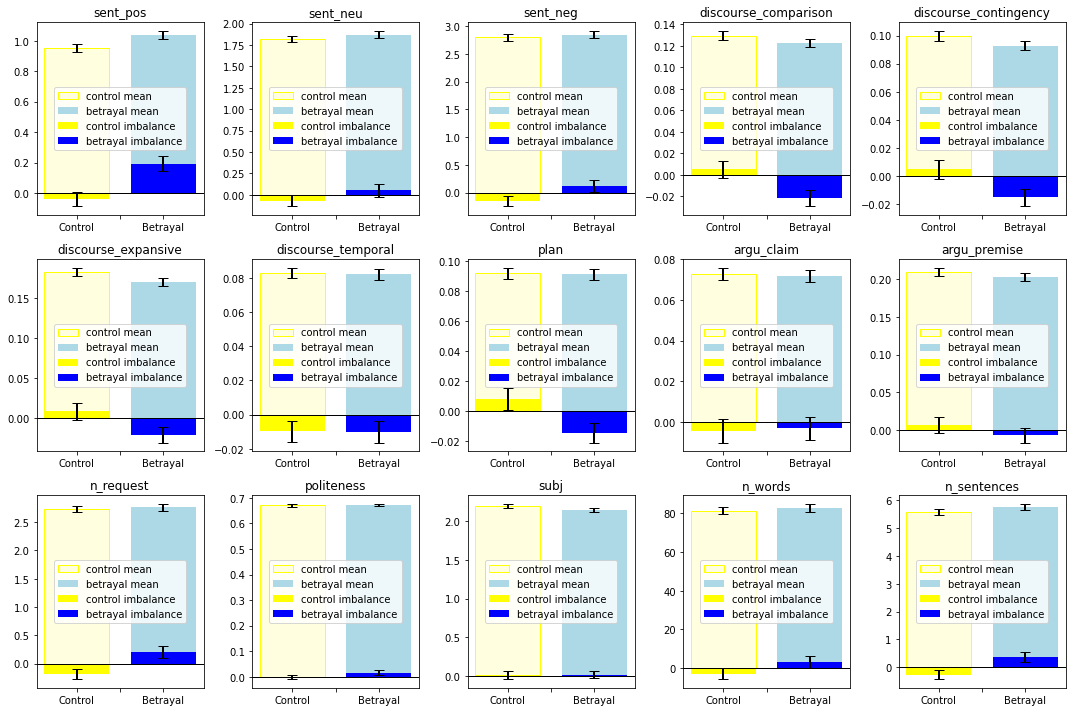

In [13]:
# plot imbalance score and mean scores of those features 
fig, ax = plt.subplots(3,5,figsize=(15,10))

for x,i in zip(betray_imb.columns,range(15)):
    sbplt = ax[math.floor(i/5), i%5]
    sbplt.axhline(y=0, linewidth=1, color='black')
    sbplt.bar(0, np.mean(Control[x]), yerr=sem(Control[x]), width=0.15, color='lightyellow', edgecolor='yellow', label='control mean', error_kw=dict(capsize=5, elinewidth=2, capthick=1, ecolor='k'))
    sbplt.bar(0.2, np.mean(Betrayal[x]), yerr=sem(Betrayal[x]), width=0.15, color='lightblue', label='betrayal mean', error_kw=dict(capsize=5, elinewidth=2, capthick=1, ecolor='k'))
    
    sbplt.bar(0, np.mean(control_imb[x]), yerr=sem(control_imb[x]), width=0.15, color='yellow', label='control imbalance', error_kw=dict(capsize=5, elinewidth=2, capthick=1, ecolor='k'))
    sbplt.bar(0.2, np.mean(betray_imb[x]), yerr=sem(betray_imb[x]), width=0.15, color='blue', label='betrayal imbalance', error_kw=dict(capsize=5, elinewidth=2, capthick=1, ecolor='k'))
    
    sbplt.legend(loc="center")
    
    labels = [item.get_text() for item in sbplt.get_xticklabels()]
    labels[1] = 'Control'
    labels[3] = 'Betrayal'
    sbplt.set_xticklabels(labels)
    sbplt.set_title(x)
    
fig.tight_layout()

As one can see from the plot, not all the features have significant imbalance. Observable imbalance can be seen for sent_pos, sent_neu, sent_neg, discourse_comparison, discourse_contingency, discourse_expansive, discourse_temporal, plan, argu_claim, argu_premise, n_request, politeness, n_words, n_sentences. However, when comparing the imbalance of control and betrayal games, we also find out that there is no big difference in balance for discourse_temporal.

Therefore, when we work on our betrayal prediction, we consider only sent_pos, sent_neu, sent_neg, discourse_comparison, discourse_contingency, discourse_expansive, plan, argu_claim, argu_premise, n_request, politeness, n_words, n_sentences.

Also, we observe that, discourse_comparison, discourse_contingency and discourse_expansive have very similar pattern, and are classified as discourse complexity feature of the message in the paper, therefore, we sum the values of them and get a single feature discourse_comp in the later prediction.

Another visualization of the distribution of imbalance:

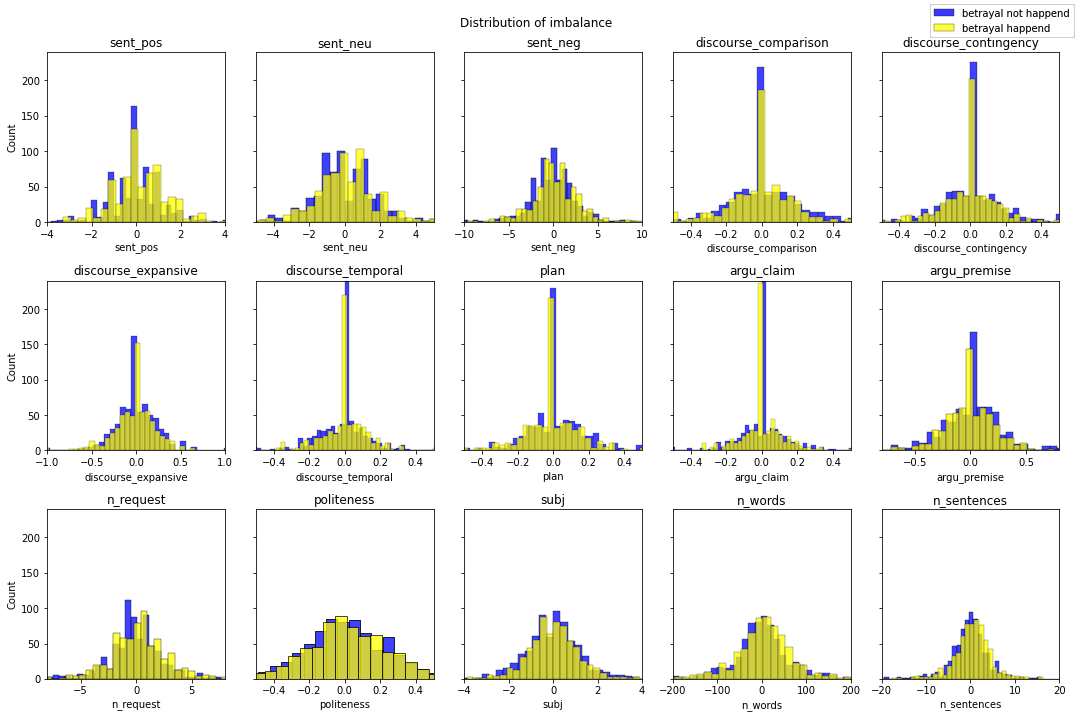

In [14]:
xrange=[(-4, 4),(-5,5),(-10,10),(-0.5,0.5),(-0.5,0.5),(-1,1),(-0.5,0.5),(-0.5,0.5),(-0.5,0.5),(-0.8,0.8),(-8,8),(-0.5,0.5),(-4,4),(-200,200),(-20,20)]
fig, axes = plt.subplots(3, 5, figsize=(15, 10), sharey=True)
fig.suptitle('Distribution of imbalance')
for x,i in zip(control_imb.columns,range(15)):
    if(i==0):
        sns.histplot(control_imb[x],ax=axes[math.floor(i/5), i%5],color='blue', label='betrayal not happend').set_title(x)
        sns.histplot(betray_imb[x],ax=axes[math.floor(i/5), i%5],color='yellow', label='betrayal happend')
    else:
        sns.histplot(control_imb[x],ax=axes[math.floor(i/5), i%5],color='blue').set_title(x)
        sns.histplot(betray_imb[x],ax=axes[math.floor(i/5), i%5],color='yellow')
    ax=axes[math.floor(i/5), i%5].set(xlim=xrange[i])
    ax=axes[math.floor(i/5), i%5].set(ylim=(0,240))
    fig.tight_layout()
    fig.legend()

Then we examine the correlation of each pair of the features:

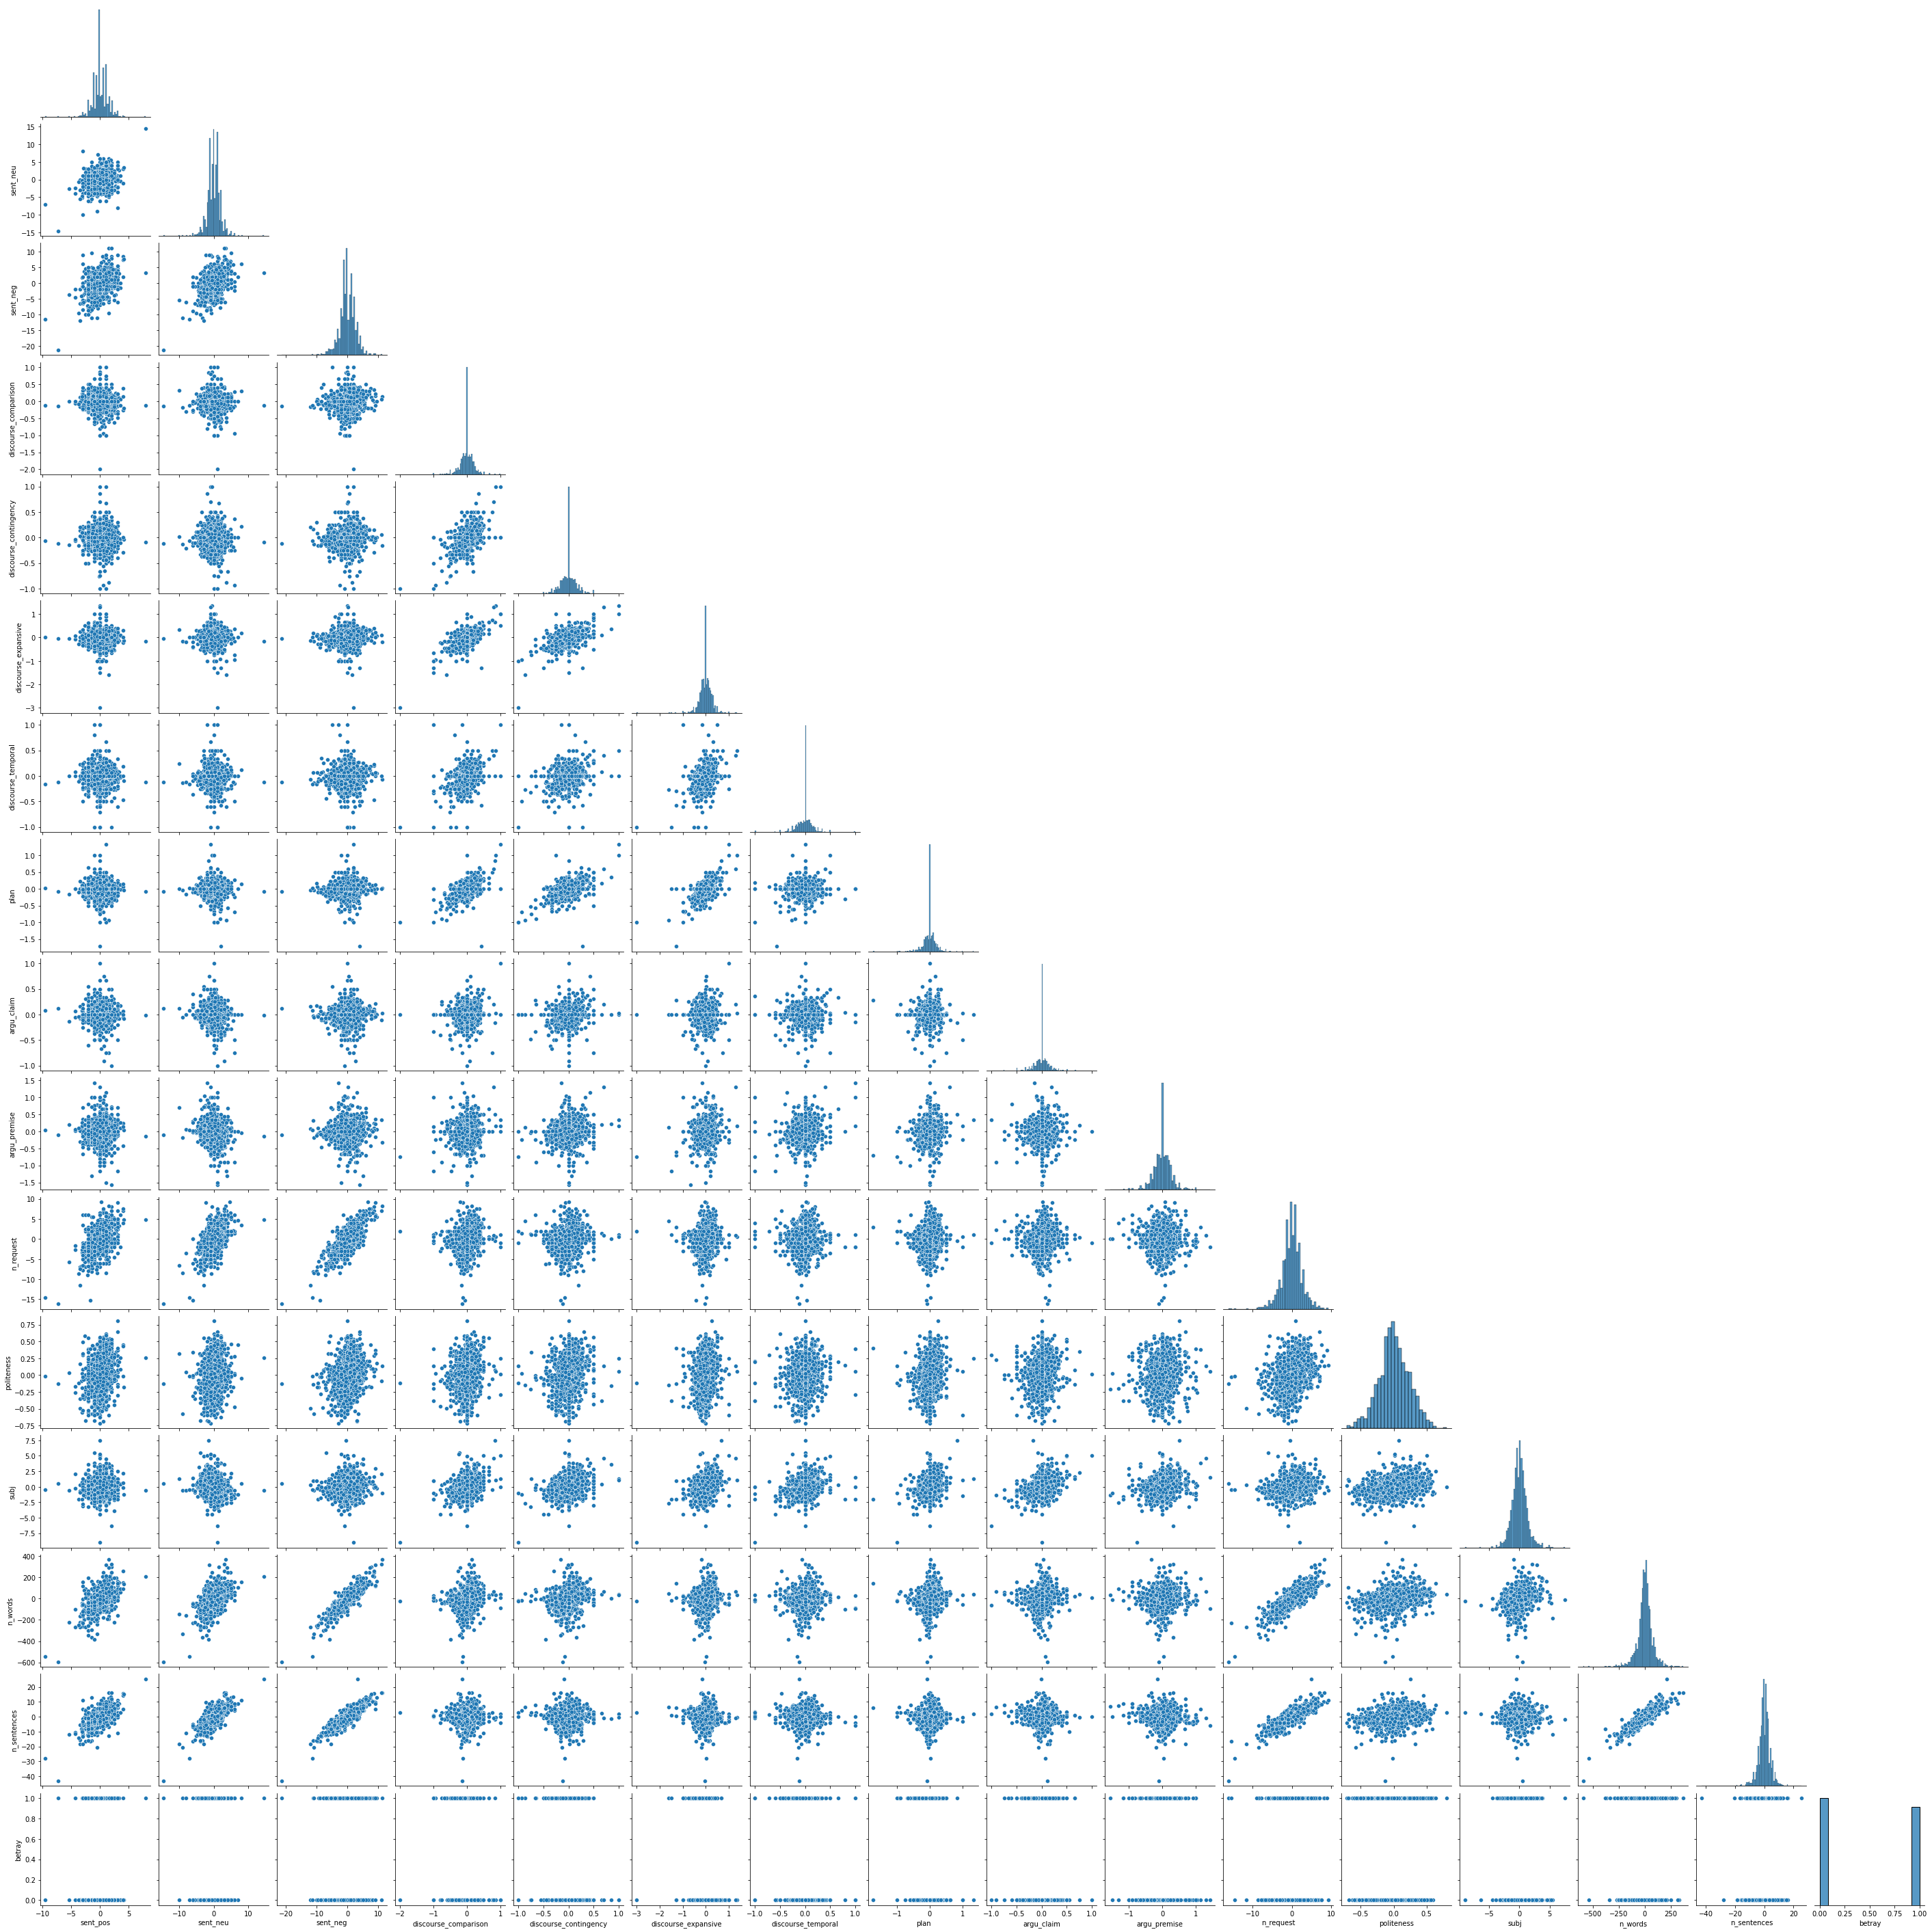

In [15]:
# show the correlation of each variables
sns.pairplot(Imbalance, corner=True)

Draw a heatmap to show their correlation:

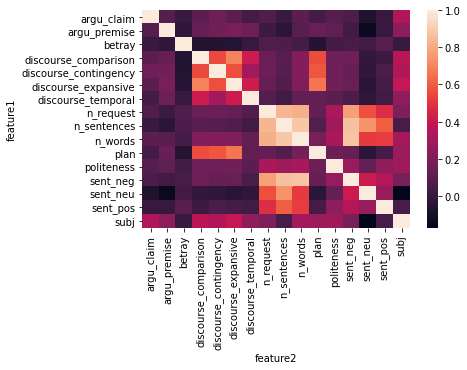

In [16]:
heat = pd.DataFrame(columns=['feature1', 'feature2', 'value'])
for i, col1 in enumerate(Imbalance.columns):
    for j, col2 in enumerate(Imbalance.columns):
        (re1, re2) = stats.pearsonr(Imbalance[col1],Imbalance[col2])
        heat.loc[i*16+j] = ([col1, col2, re1])

heat = heat.pivot(index="feature1", columns="feature2", values="value")
ax = sns.heatmap(heat)
plt.xlabel = Imbalance.columns
plt.show()

We draw a graph to visualize the connection between each pair of variables whose pearson value is larger than 0.4:

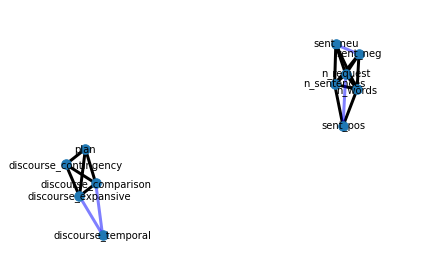

In [17]:
# construct a graph
G = nx.Graph()

for col1 in Imbalance.columns:
    for col2 in Imbalance.columns:
        (re1, re2) = stats.pearsonr(Imbalance[col1],Imbalance[col2])
        # thresholding, we consider pearson value > 0.4 as correlated
        if(col1!=col2 and re2<0.1 and abs(re1)>0.4):
            G.add_edge(col1, col2, weight=re1)
            #print("Pearson value for {} and {} is {:4f}, p-value is {:4f}".format(col1, col2, re1, re2))

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

# positions for all nodes
pos = nx.spring_layout(G, seed=7)  

# nodes
nx.draw_networkx_nodes(G, pos, node_size=90)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=3)
nx.draw_networkx_edges(G, pos, edgelist=esmall, width=3, alpha=0.5, edge_color="b")

# labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

ax = plt.gca()
ax.margins(0.2)
plt.axis("off")
plt.tight_layout()
plt.show()

From the previous two graphs, we can see that there are correlation between some pairs of features. We find out that:

a) planing is highly related to discourse complexity

b) sentiment is related to number of request, number of words and number of sentences

c) number of request is also related to sentiment, number of words and number of sentences 

d) number of words is highly related to number of sentences

Therefore, we will consider the interaction between those pairs of variables in the coming prediction tasks.